In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPooling1D, Input, concatenate
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
df = pd.read_csv('1_augmented_df.csv')
df.head()

,text,label
0,washington reuters head conservative republica...,1
1,washington reuters transgender people allowed ...,1
2,washington reuters special counsel investigati...,1
3,washington reuters trump campaign adviser geor...,1
4,seattlewashington reuters president donald tru...,1


In [3]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [4]:
# Tokenization and padding
X_train = pd.Series(X_train).fillna("").astype(str)
X_test = pd.Series(X_test).fillna("").astype(str)
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=1000)
X_test_pad = pad_sequences(X_test_seq, maxlen=1000)

In [5]:
# Load pre-trained word embeddings (GloVe)
def load_glove_embeddings():
    embeddings_index = {}
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_index = load_glove_embeddings()
embedding_dim = 100
embedding_matrix = np.zeros((10000, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < 10000:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [6]:
# Define Bidirectional LSTM model
def build_bilstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=1000, weights=[embedding_matrix], trainable=False))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adamax(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Train and evaluate models
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2)
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1, y_pred

In [7]:
def check_gpu():
    if tf.config.list_physical_devices('GPU'):
        print("GPU is detected and available!")
    else:
        print("No GPU detected. TensorFlow will use the CPU.")
        
check_gpu()

GPU is detected and available!


In [8]:
# Bidirectional LSTM model
bilstm_model = build_bilstm_model()
bilstm_accuracy, bilstm_precision, bilstm_recall, bilstm_f1, y_pred = train_and_evaluate(bilstm_model, X_train_pad, y_train, X_test_pad, y_test)
print(f"Bidirectional LSTM - Accuracy: {bilstm_accuracy}, Precision: {bilstm_precision}, Recall: {bilstm_recall}, F1: {bilstm_f1}")

Epoch 1/15
470/470 [==============================] - 74s 149ms/step - loss: 0.1284 - accuracy: 0.9531 - val_loss: 0.0242 - val_accuracy: 0.9945
Epoch 2/15
470/470 [==============================] - 69s 147ms/step - loss: 0.0176 - accuracy: 0.9955 - val_loss: 0.0081 - val_accuracy: 0.9980
Epoch 3/15
470/470 [==============================] - 67s 142ms/step - loss: 0.0101 - accuracy: 0.9975 - val_loss: 0.0105 - val_accuracy: 0.9969
Epoch 4/15
470/470 [==============================] - 64s 137ms/step - loss: 0.0074 - accuracy: 0.9982 - val_loss: 0.0061 - val_accuracy: 0.9987
Epoch 5/15
470/470 [==============================] - 67s 142ms/step - loss: 0.0064 - accuracy: 0.9986 - val_loss: 0.0054 - val_accuracy: 0.9988
Epoch 6/15
470/470 [==============================] - 66s 140ms/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 0.0046 - val_accuracy: 0.9989
Epoch 7/15
470/470 [==============================] - 66s 140ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0044 - val_ac

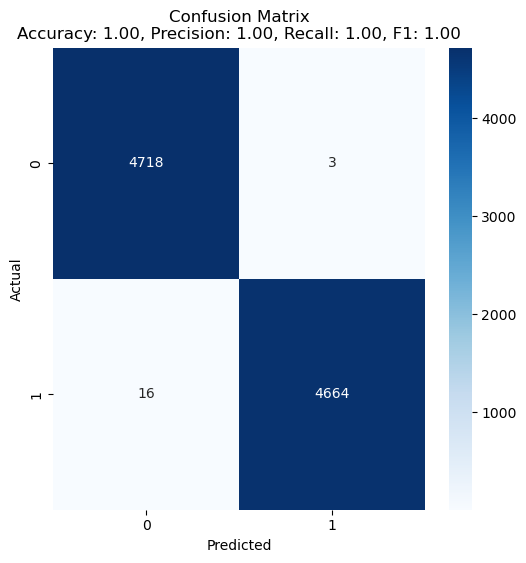

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, accuracy, precision, recall, f1):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')
    plt.show()

plot_confusion_matrix(y_test, y_pred, bilstm_accuracy, bilstm_precision, bilstm_recall, bilstm_f1)

In [10]:
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Make sure to download NLTK resources beforehand
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ashis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ashis\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [11]:
# Preprocessing function from your notebook
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Prediction function with preprocessing
def predict_user_input(tokenizer, model, maxlen=1000):
    user_input = input("Enter a news article or headline:\n")
    clean_text = preprocess_text(user_input)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq, maxlen=maxlen)
    prediction = model.predict(padded)[0][0]
    label = "True" if prediction > 0.5 else "Fake"
    print(f"\nPrediction: {label} (Confidence: {prediction:.4f})")

In [12]:
# Example usage
for _ in range(4):
    predict_user_input(tokenizer, bilstm_model)

Enter a news article or headline:
 MADRID (Reuters) - Spain s northeastern region of Catalonia, hit last week by two Islamist militant attacks which killed 15 people, is to deploy more police, install bollards in Barcelona and step up security around stations and tourist landmarks. The aim is to strike a balance between security and not overloading residents with restrictions.  We re looking at introducing (street) obstacles that could be mobile,  Joaquin Forn, who is in charge of home affairs in Catalonia, told a news conference on Wednesday. A van plowed into crowds of holidaymakers and local residents on Barcelona s crowded Las Ramblas boulevard last Thursday, killing 13 people. Two others were killed during the driver s getaway and in a separate attack in Cambrils. The Barcelona rampage reignited a row over how cities can better prevent such attacks. Militants have used trucks and cars as weapons to kill nearly 130 people in France, Germany, Britain, Sweden and Spain over the past 

1/1 [==============================] - 0s 51ms/step

Prediction: True (Confidence: 1.0000)


Enter a news article or headline:
 COPENHAGEN (Reuters) - Danish police said on Tuesday the size of a headless female torso found on the sea s edge in Copenhagen suggested it could be that of a Swedish journalist who died after taking a submarine ride with the vessel s Danish inventor. Police said divers were still searching the area and they were investigating reports of other body parts that may have been spotted in Copenhagen harbor. Danish inventor Peter Madsen has been charged with killing Kim Wall, a Swedish journalist, in his home-made submarine.   We re dealing with a torso where arms, legs and head were cut off deliberately. The length of the torso doesn t speak against it being Kim Wall, but we still don t know,  Copenhagen police spokesman Jens Moller said in a video statement. Madsen told a court she had died in an accident on board the submarine and that he had buried her at sea, changing his earlier statement that he dropped her off alive in Copenhagen. Police are conduct

1/1 [==============================] - 0s 41ms/step

Prediction: True (Confidence: 1.0000)


Enter a news article or headline:
 While on the campaign trail, candidate Donald Trump, a former reality show star, repeatedly mocked Sen. Marco Rubio for that time he drank water on the stage. Trump mocked Rubio at rallies about that and on Twitter, too. As they say, with this guy, there really is a tweet for everything. Trump did this after he kicked off his day blasting that  loser  network CNN, the  failing  New York Times and demanded a  thank you  from the UCLA basketball players who arrived in the states after being released from China. Then he summarized his trip to Asia, declaring it to be  the longest visit to the region by an American president in more than a quarter of a century.  He added that  America is back and the future has never looked better.  Then he seemed to have difficulty breathing and paused for water.Here is Trump doing that think he disparaged Rubio for doing:more proof that we're living in a simulation pic.twitter.com/7fGMxvRKUj  kevin driscoll (@kevndrisco

1/1 [==============================] - 0s 32ms/step

Prediction: Fake (Confidence: 0.0000)


Enter a news article or headline:
 Shawn Helton 21st Century WireEarlier this week Apple CEO Tim Cook publicly rejected an unprecedented US Federal Court order that would force the company to decrypt an iPhone linked to one of the San Bernardino shooters   a move that would have vast implications  PRIVACY & PROTECTION: Apple CEO Tim Cook challenges FBI court order to unlock private data of users (Image Source: Iphoneitalia)Breaching Public Privacy In a published open letter entitled,  A Message to Our Customers,   Apple CEO Tim Cook strikingly opposed a recent federal court ruling that would unlock a phone that s been connected to the San Bernardino Mass Shooting case.The FBI ruling stipulates that Apple must provide access for one time only. However, cyber security experts and technology companies insist this is a virtual impossibility and a guarantee that cannot be made.In theory, the decryption of the phone would be opened via a newly created operating system that would give the FBI

1/1 [==============================] - 0s 35ms/step

Prediction: Fake (Confidence: 0.0000)
